In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
train = pd.read_csv('train.csv')

Drop outliers:

In [4]:
train = train[train['GrLivArea'] <= 4000]

Fill missing values according to logic that NaN represent abscence of the particular feature in the house

In [5]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].fillna('N_A', inplace=True)
    else:
        train[col].fillna(0, inplace=True)

Generated feature - years scince renovation:

In [6]:
train['yr_since_renovation'] = (train['YrSold'] - train['YearRemodAdd'])

Keep only residential properties

In [7]:
train = train.loc[train['MSZoning'].isin(['RH', 'RL', 'RP', 'RM'])]

Cathegories transformation:

In [8]:
train.loc[(train['Exterior1st'].isin(['AsbShng', 'AsphShn', 'BrkComm', 'CBlock'])), 'Exterior1st'] = 'Lvl_1'
train.loc[(train['Exterior1st'].isin(['HdBoard', 'MetalSd', 'Plywood', 'Stucco', 'Wd Sdng', 'WdShing'])), 'Exterior1st'] = 'Lvl_2'
train.loc[(train['Exterior1st'].isin(['VinylSd', 'BrkFace', 'CemntBd', 'Stone', 'ImStucc'])), 'Exterior1st'] = 'Lvl_3'

In [9]:
train.loc[(train['MasVnrType'].isin(['BrkFace', 'NA'])), 'MasVnrType'] = 'Lvl_2'
train.loc[(train['MasVnrType'].isin(['BrkCmn', 'None'])), 'MasVnrType'] = 'Lvl_1'
train.loc[(train['MasVnrType'].isin(['Stone'])), 'MasVnrType'] = 'Lvl_3'

In [10]:
train.loc[(train['MasVnrArea'] == 0), 'MasVnrArea'] = 0
train.loc[(train['MasVnrArea'] > 0), 'MasVnrArea'] = 1

In [11]:
train.loc[(train['ExterQual'].isin(['Fa', 'TA'])), 'ExterQual'] = 0
train.loc[(train['ExterQual'].isin(['Ex', 'Gd'])), 'ExterQual'] = 1

In [12]:
train.loc[(train['ExterCond'].isin(['Fa', 'Po'])), 'ExterCond'] = 0
train.loc[(train['ExterCond'].isin(['Ex', 'Gd', 'TA'])), 'ExterCond'] = 1

In [13]:
train.loc[(~train['Foundation'].isin(['PConc'])), 'Foundation'] = 0
train.loc[(train['Foundation'].isin(['PConc'])), 'Foundation'] = 1

In [14]:
train.loc[(train['BsmtQual'].isin(['Gd', 'Ex'])), 'BsmtQual'] = 1
train.loc[(train['BsmtQual'].isin(['Fa', 'NA', 'TA'])), 'BsmtQual'] = 0

In [15]:
train.loc[(train['BsmtCond'].isin(['Gd', 'TA'])), 'BsmtCond'] = 1
train.loc[(train['BsmtCond'].isin(['Fa', 'NA', 'Po'])), 'BsmtCond'] = 0

In [16]:
train.loc[(train['BsmtExposure'].isin(['Gd', 'Av', 'Mn'])), 'BsmtExposure'] = 1
train.loc[(train['BsmtExposure'].isin(['NA', 'No'])), 'BsmtExposure'] = 0

In [17]:
train.loc[(train['HeatingQC'].isin(['Ex'])), 'HeatingQC'] = 1
train.loc[(train['HeatingQC'].isin(['Fa', 'Gd', 'Po', 'TA'])), 'HeatingQC'] = 0

In [18]:
train.loc[(~train['Electrical'].isin(['SBrkr', 'NA'])), 'Electrical'] = 0
train.loc[(train['Electrical'].isin(['SBrkr', 'NA'])), 'Electrical'] = 1

In [19]:
train.loc[(train['BsmtFullBath'] > 0), 'BsmtFullBath'] = 1

In [20]:
train.loc[(train['FullBath'] <= 1), 'FullBath'] = 1
train.loc[(train['FullBath'] > 1), 'FullBath'] = 2

In [21]:
train.loc[(train['Fireplaces'] >= 1), 'Fireplaces'] = 1

In [22]:
train.loc[(train['FireplaceQu'].isin(['Gd', 'TA'])), 'FireplaceQu'] = 'Gd'
train.loc[(train['FireplaceQu'].isin(['Fa', 'NA', 'Po'])), 'FireplaceQu'] = 'Low'

Drop unnecessaries

In [23]:
train.drop('Id', axis=1, inplace=True)

In [24]:
train.drop('LotFrontage', axis=1, inplace=True)

Transformation into ordinal feature:

In [25]:
neighborhoods = (train.groupby('Neighborhood')['SalePrice']
                 .agg(['mean', 'median', 'count'])
                 .sort_values(by='median', ascending=False))

In [26]:
n_sorted = neighborhoods.sort_values(by='median').index

In [27]:
for i, n in enumerate(n_sorted):
    train.loc[train['Neighborhood'] == n, 'neighborhoods_ordinal'] = int(i+1)

In [28]:
train.drop('Neighborhood', axis=1, inplace=True)

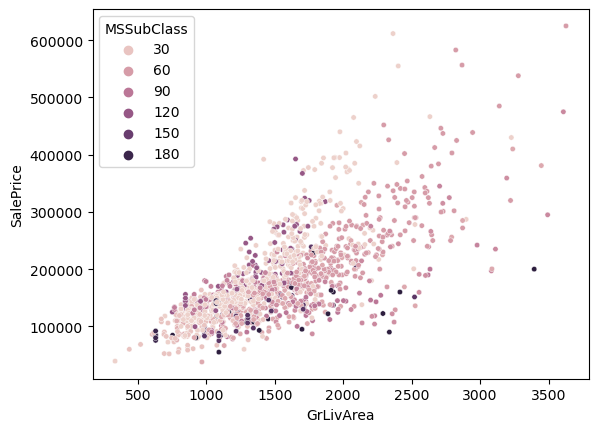

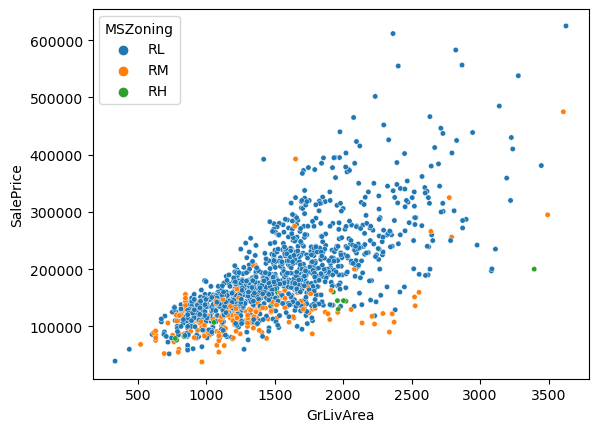

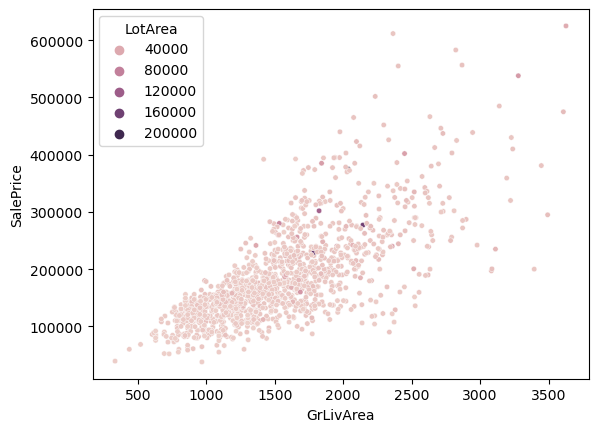

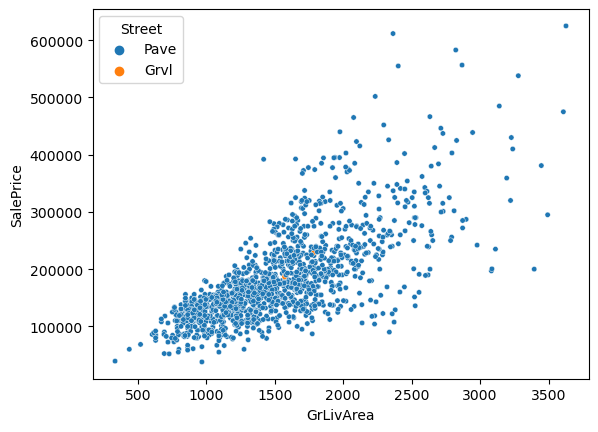

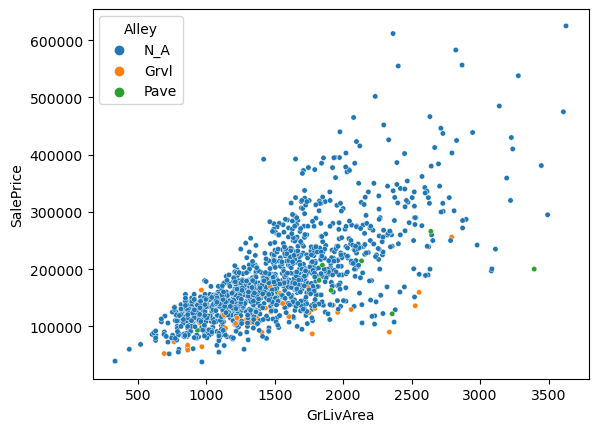

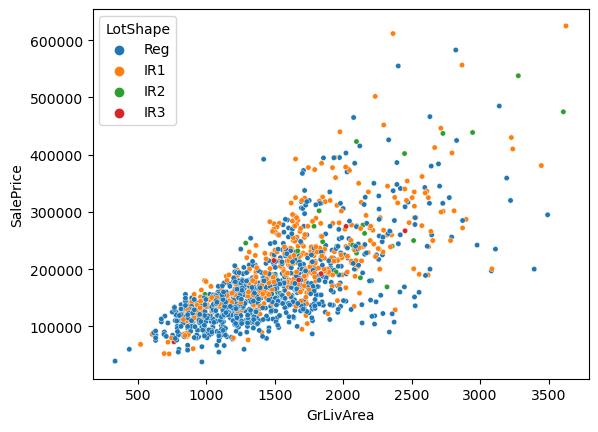

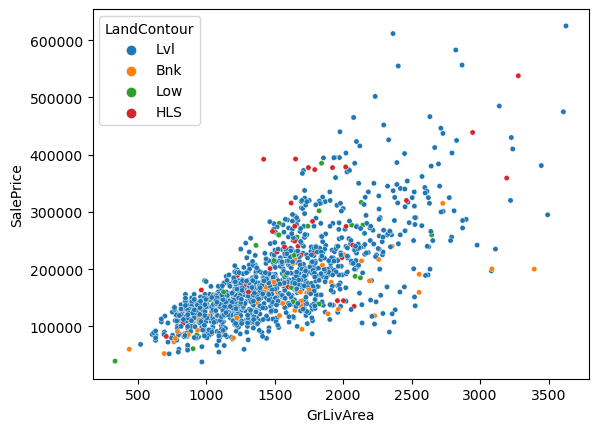

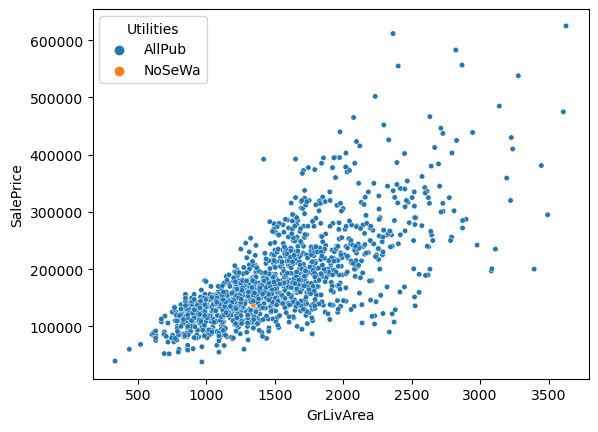

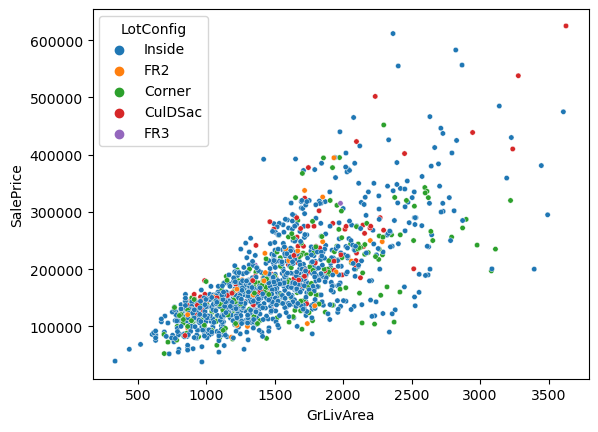

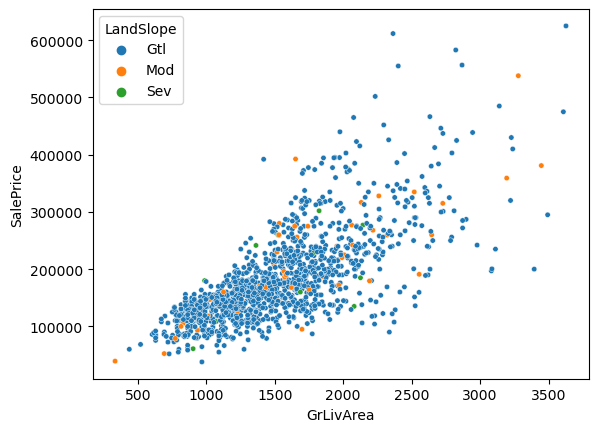

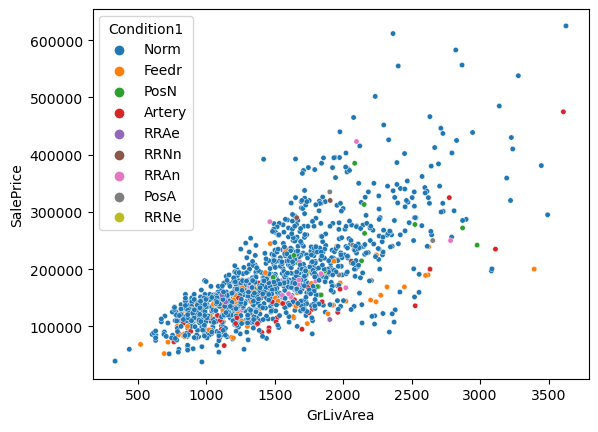

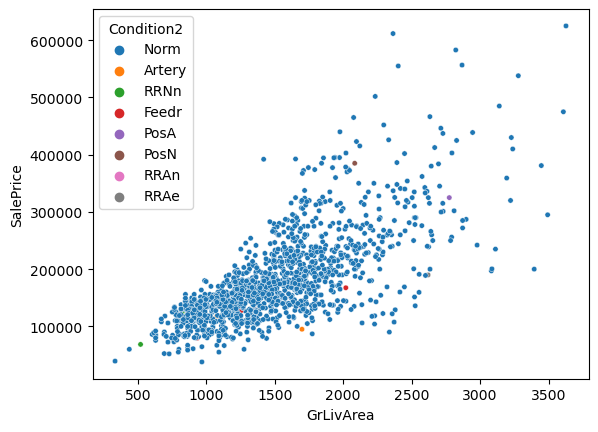

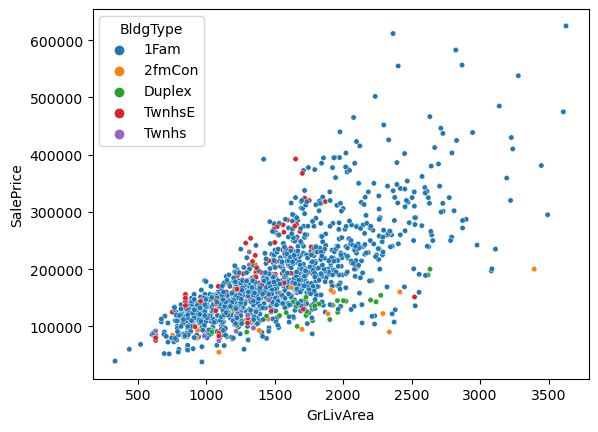

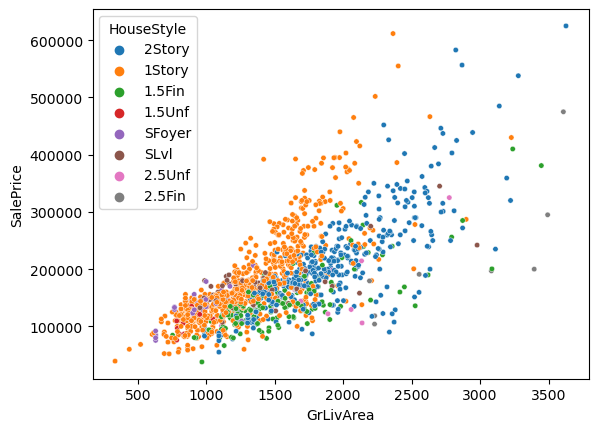

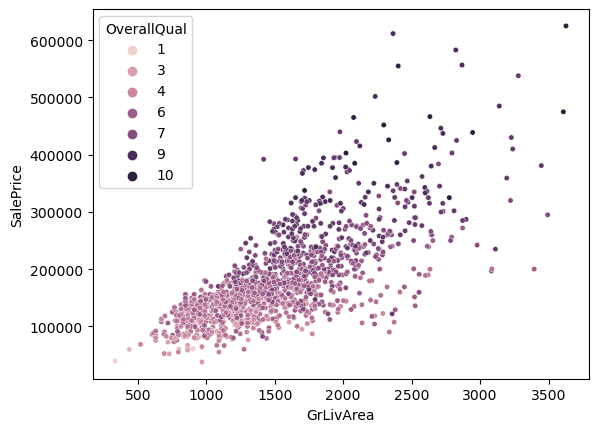

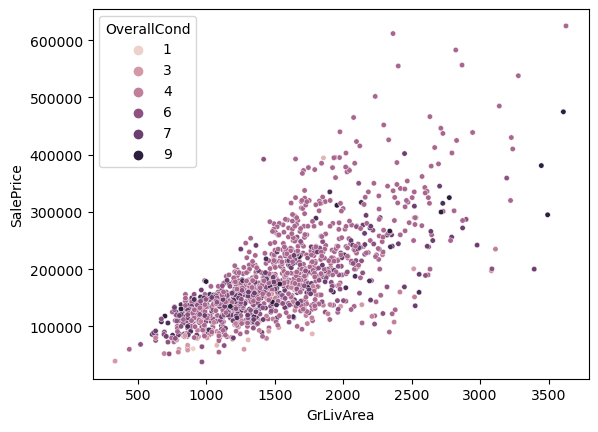

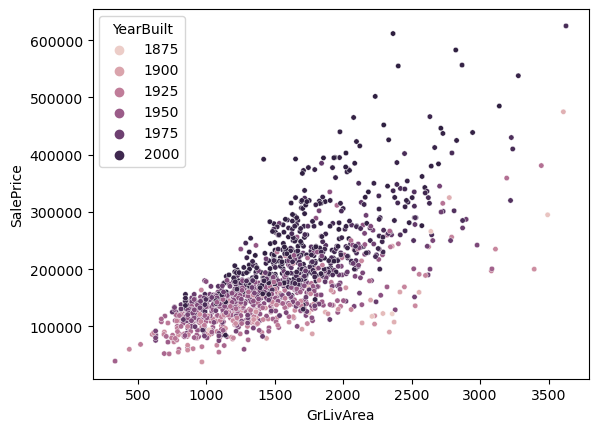

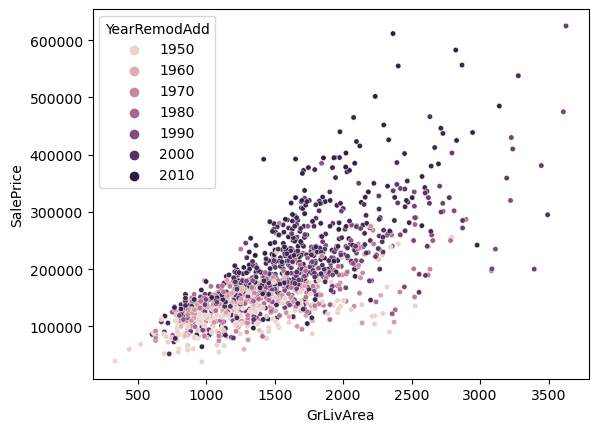

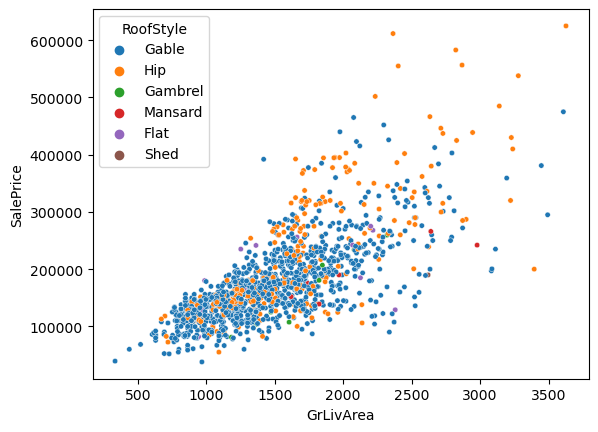

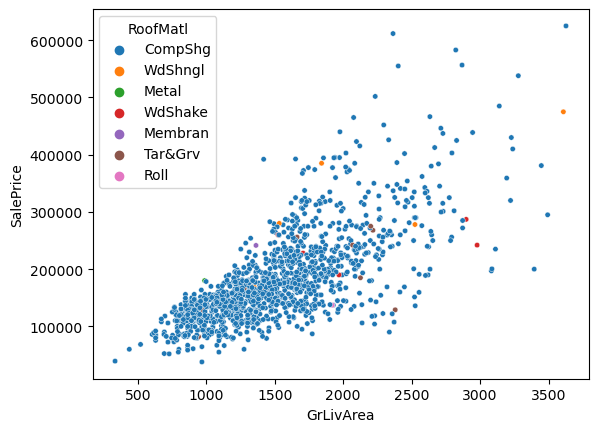

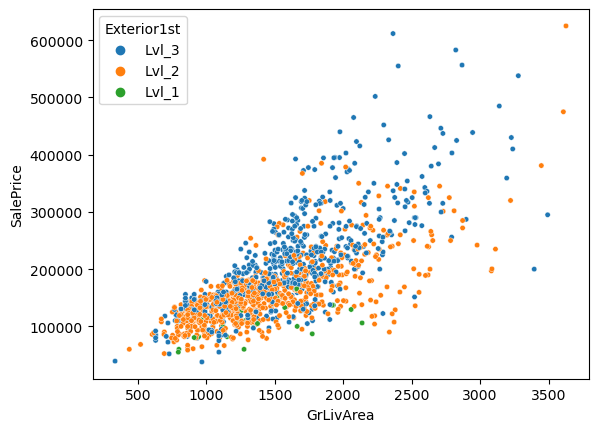

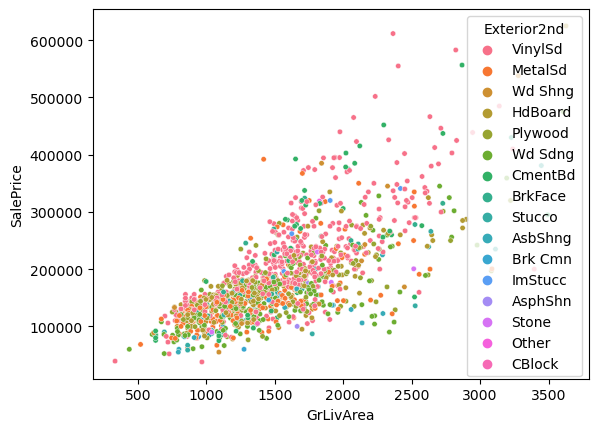

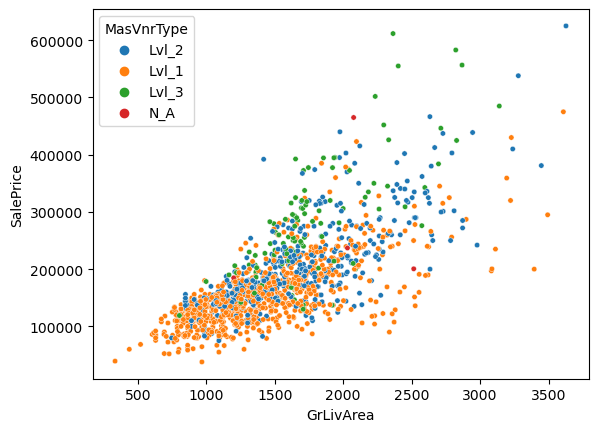

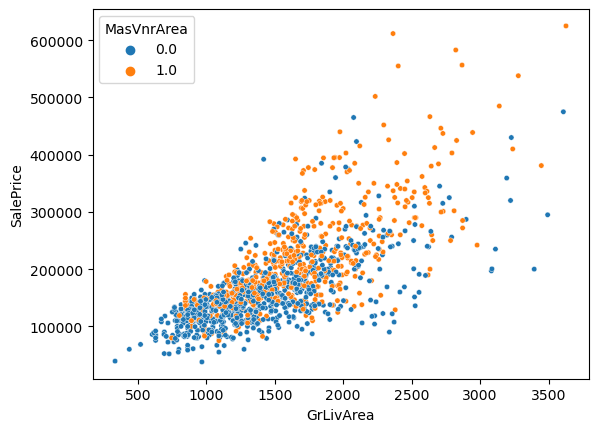

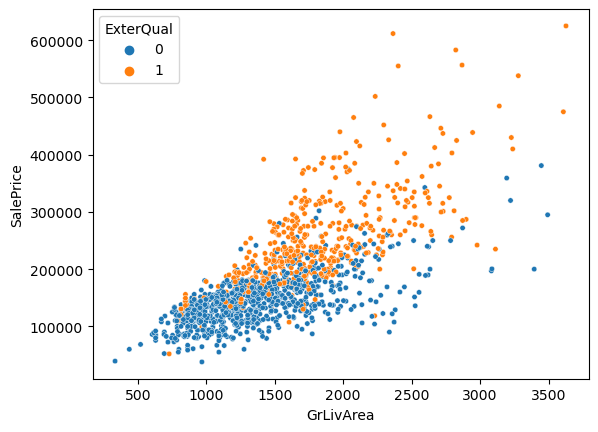

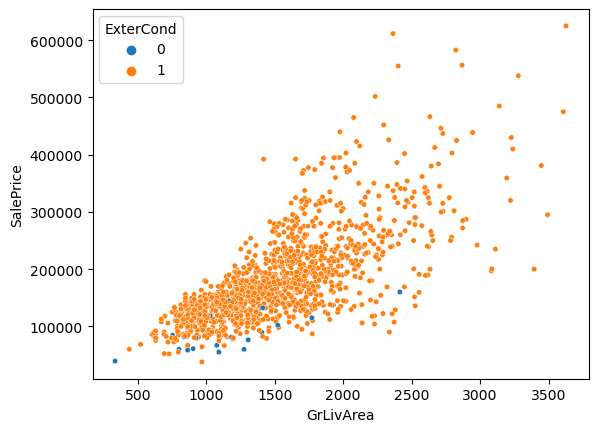

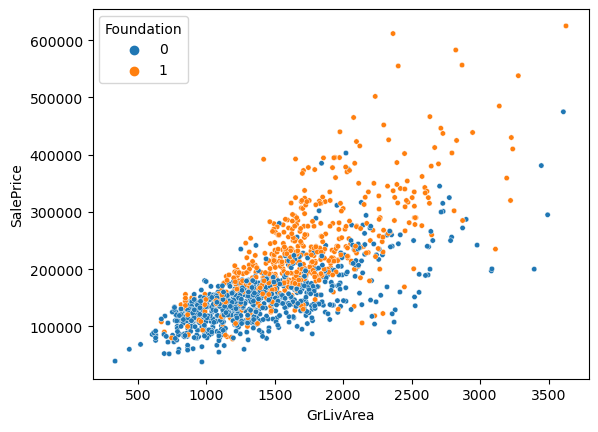

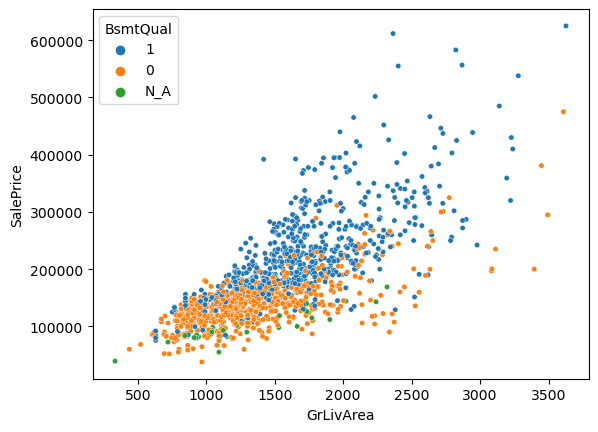

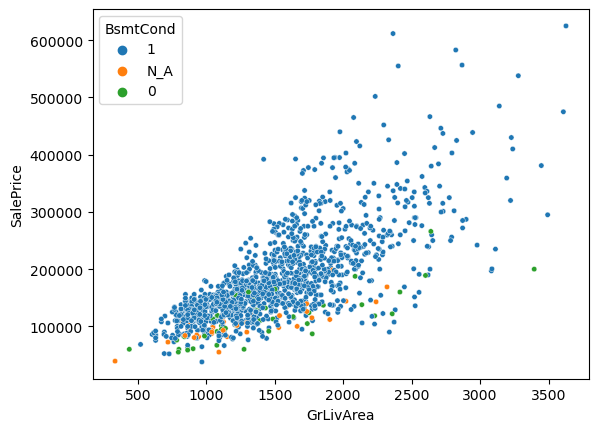

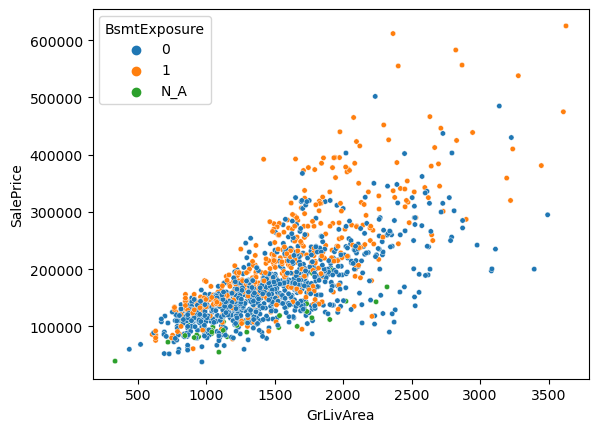

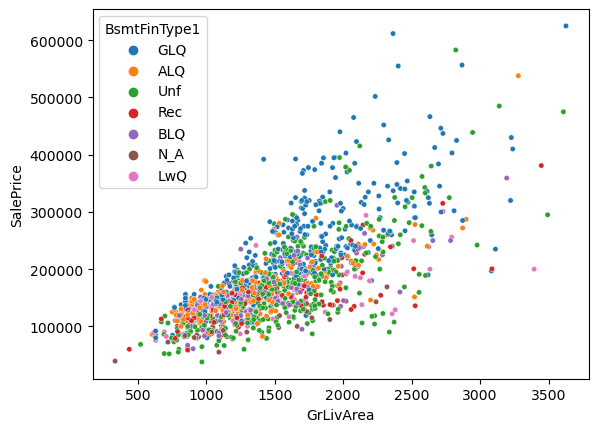

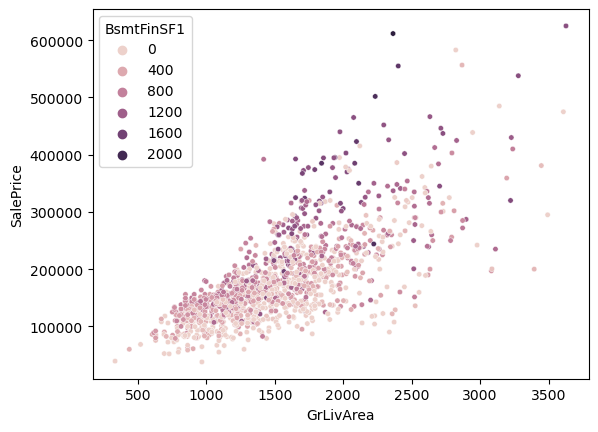

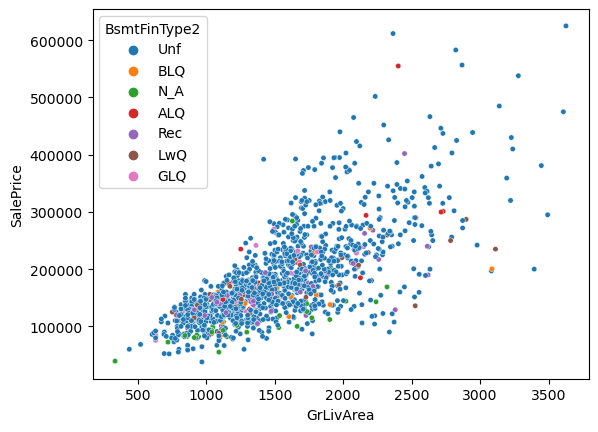

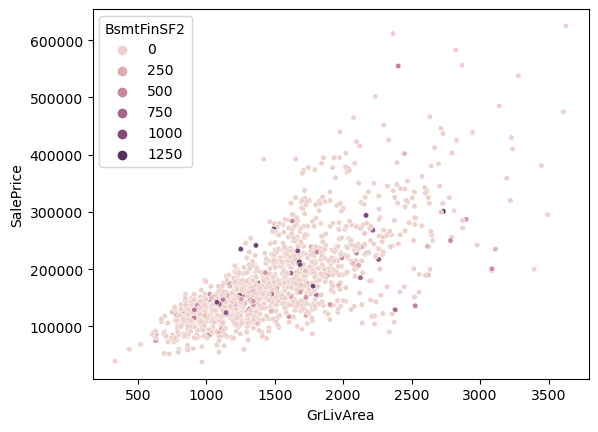

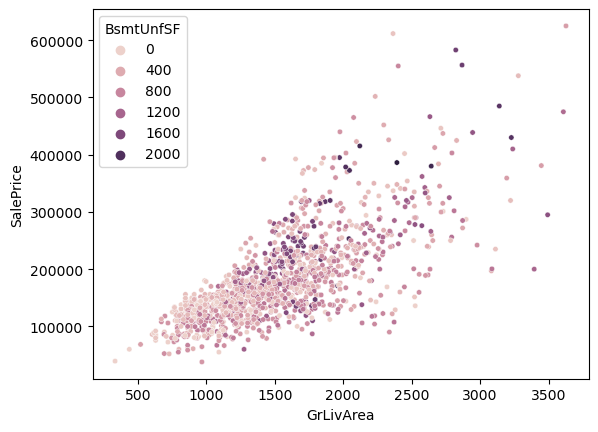

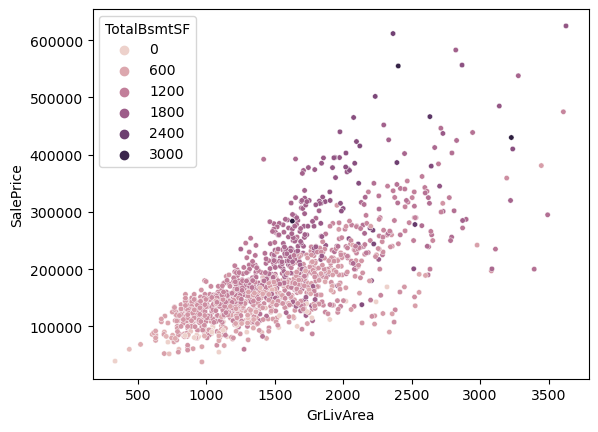

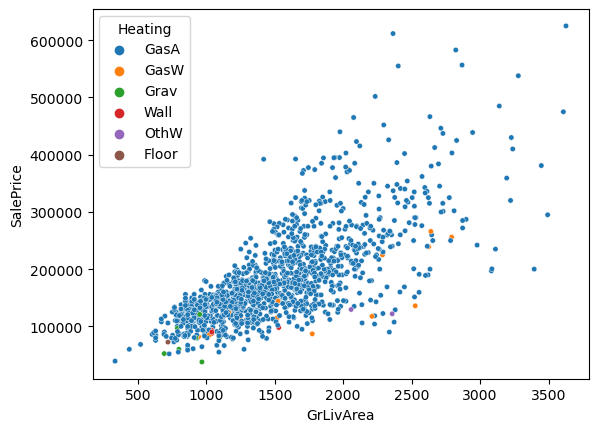

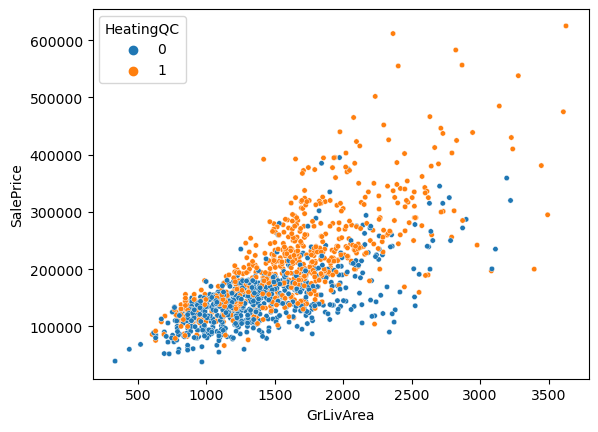

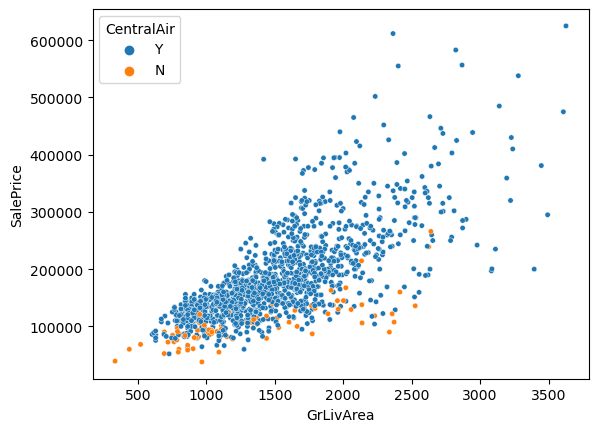

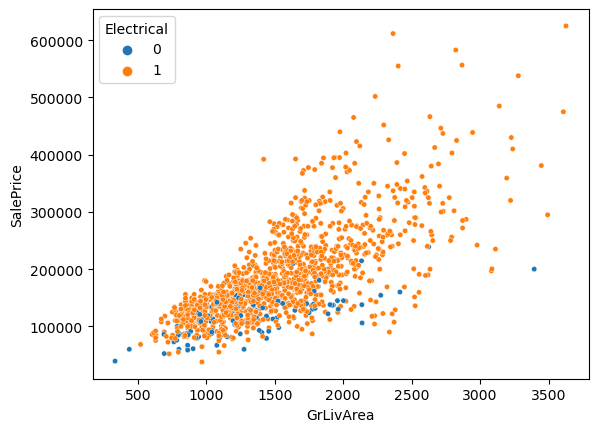

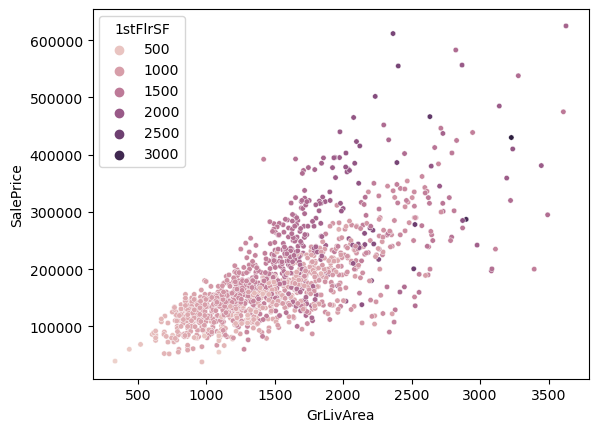

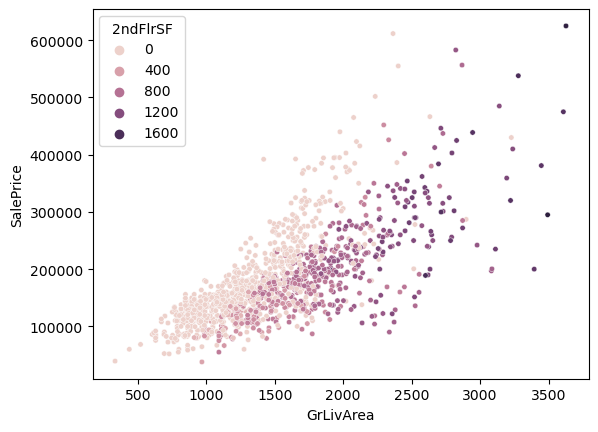

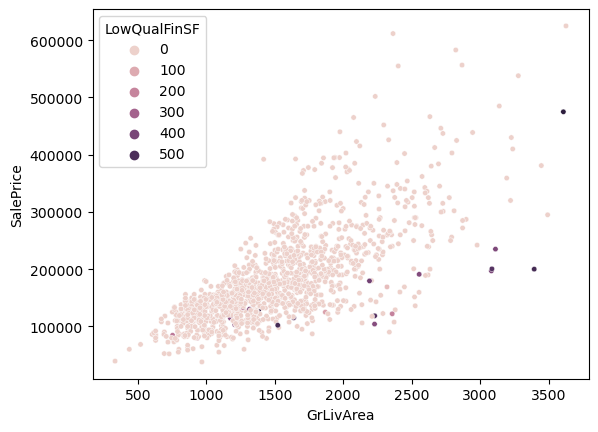

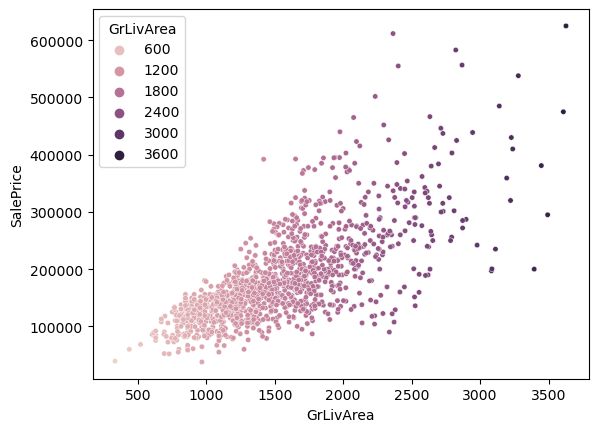

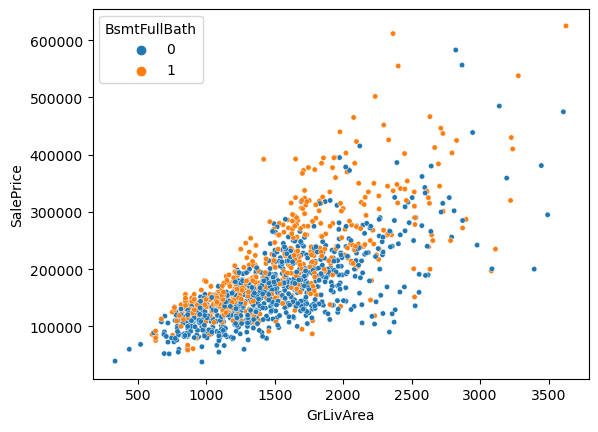

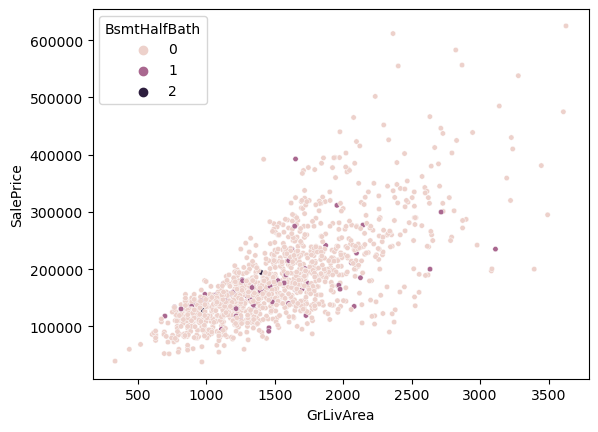

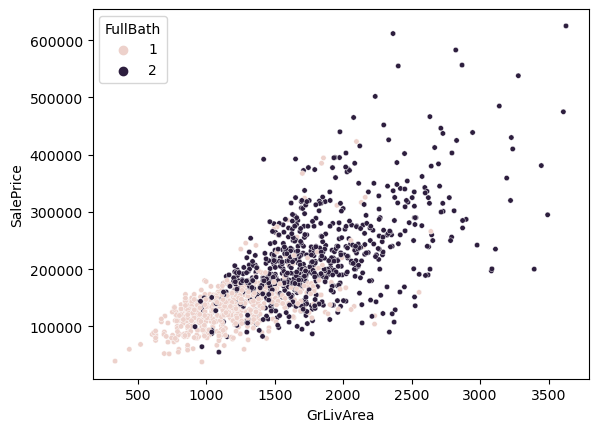

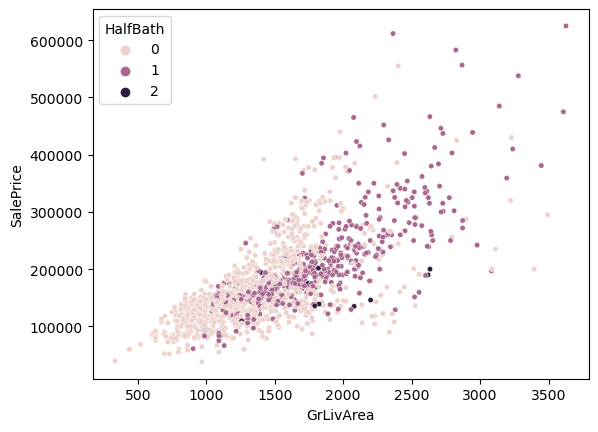

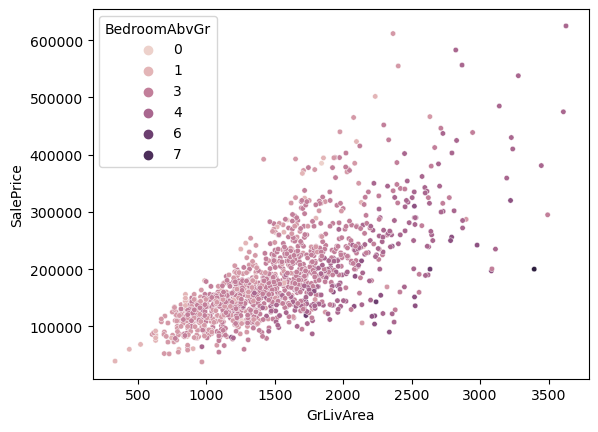

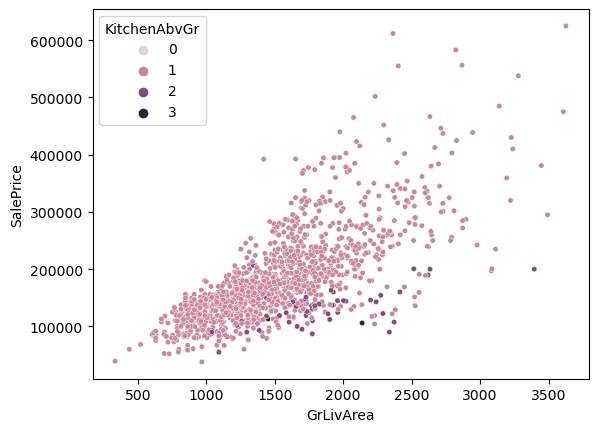

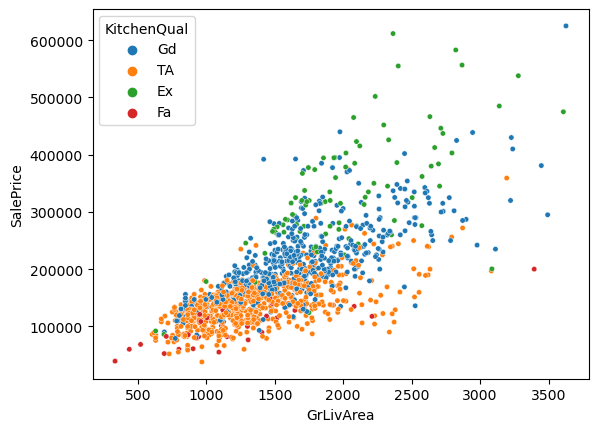

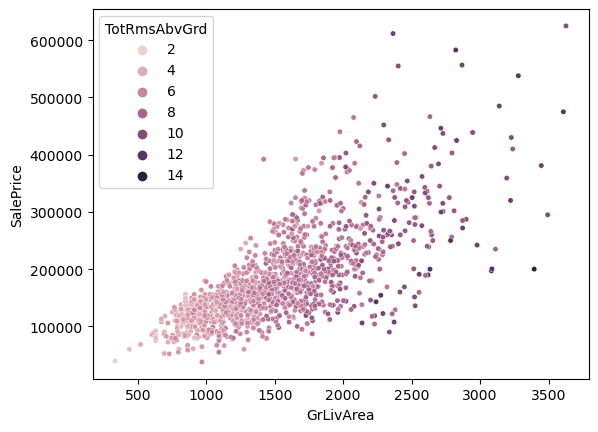

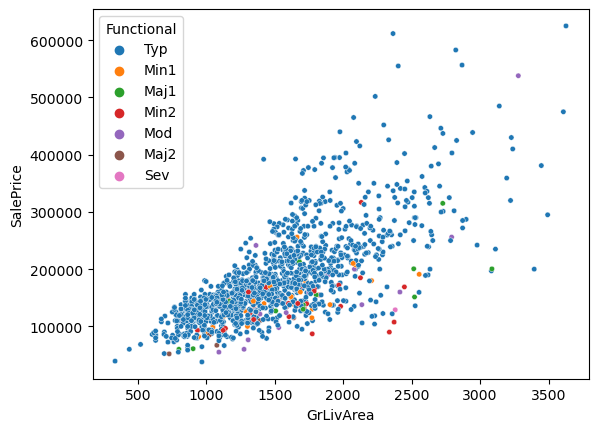

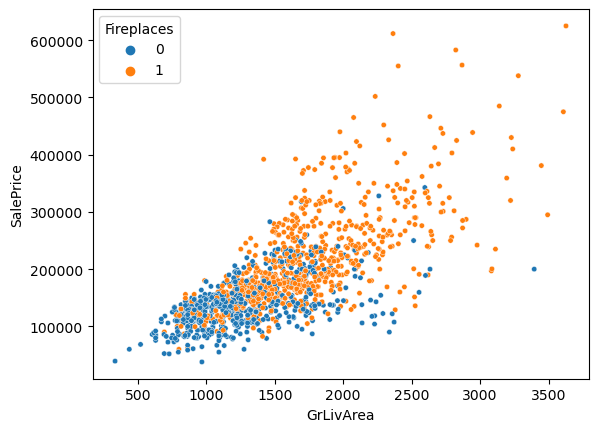

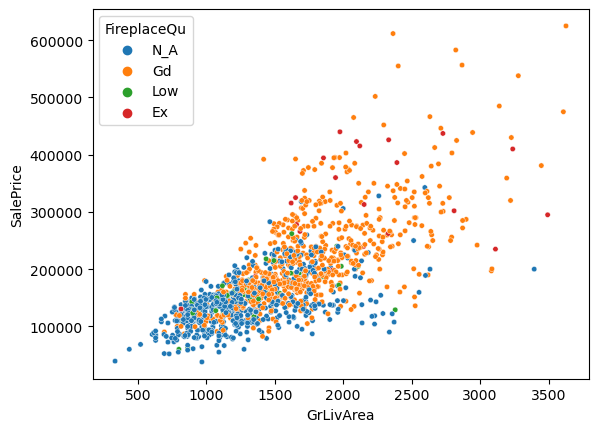

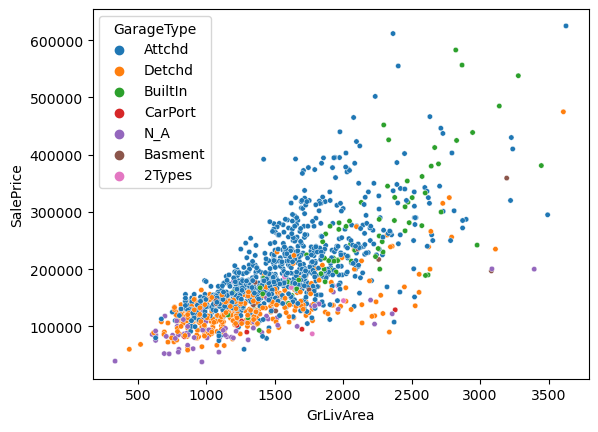

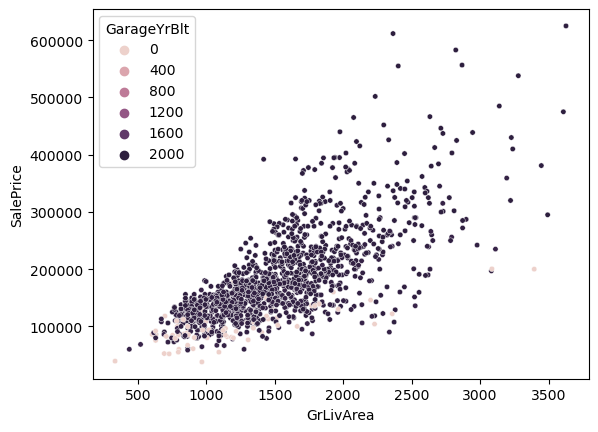

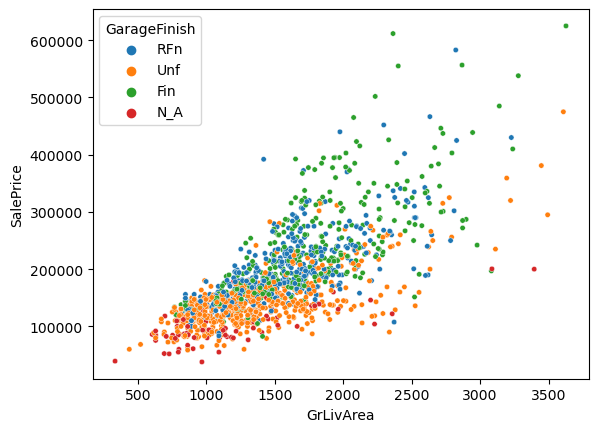

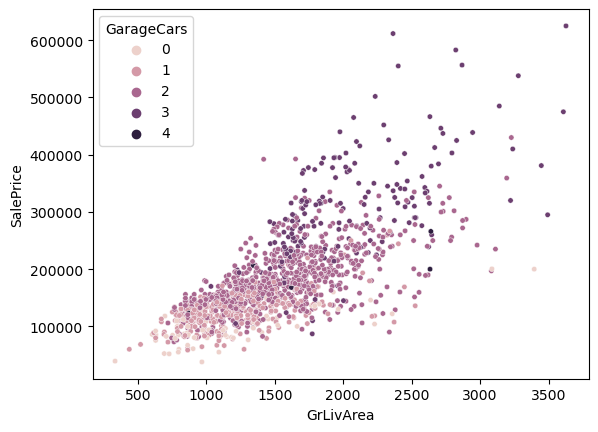

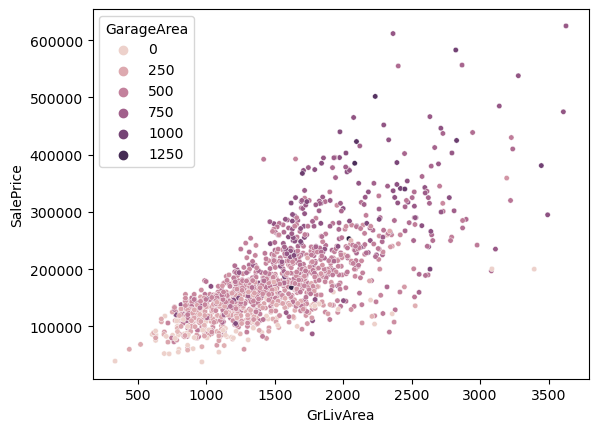

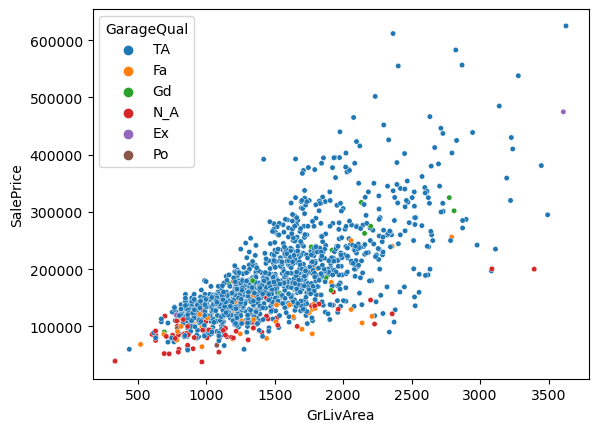

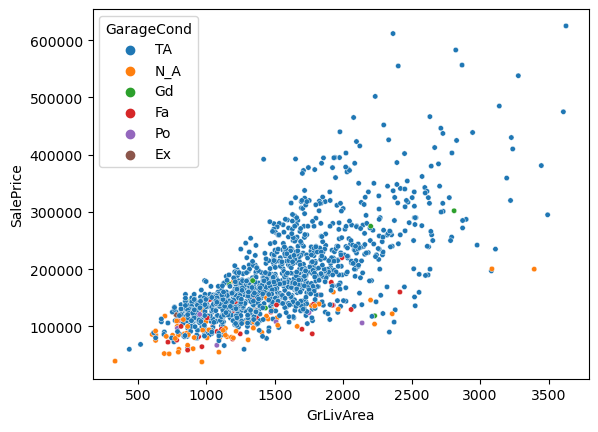

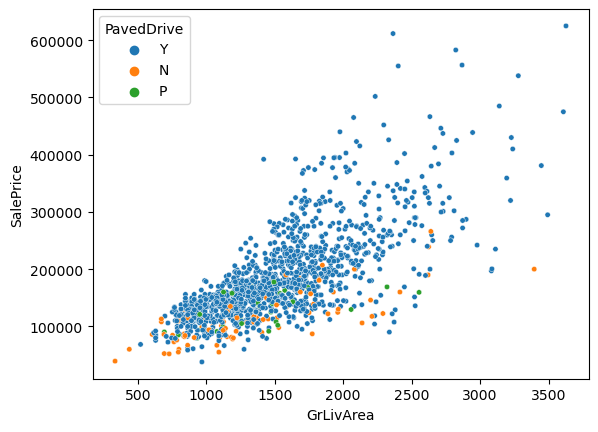

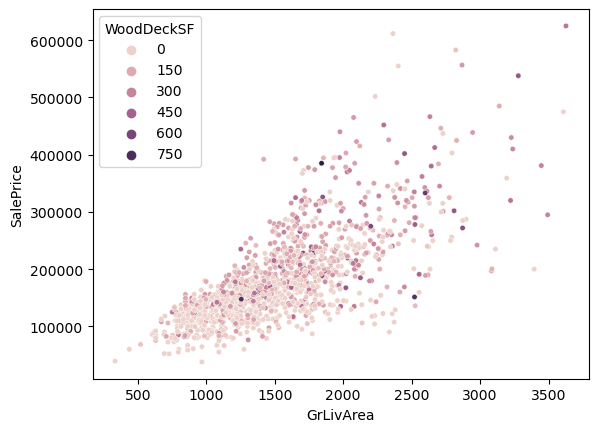

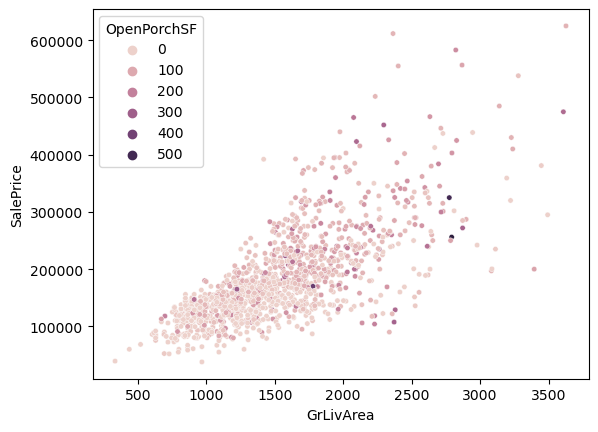

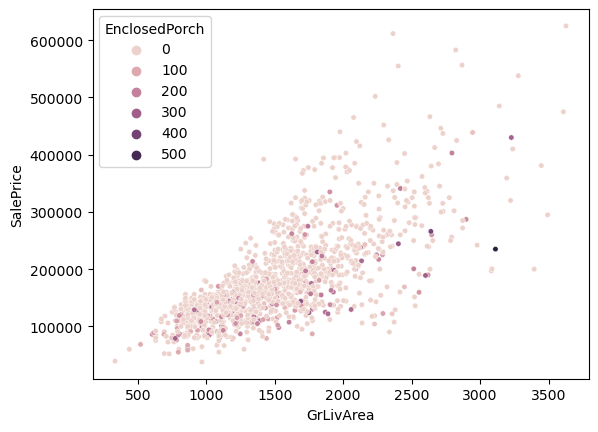

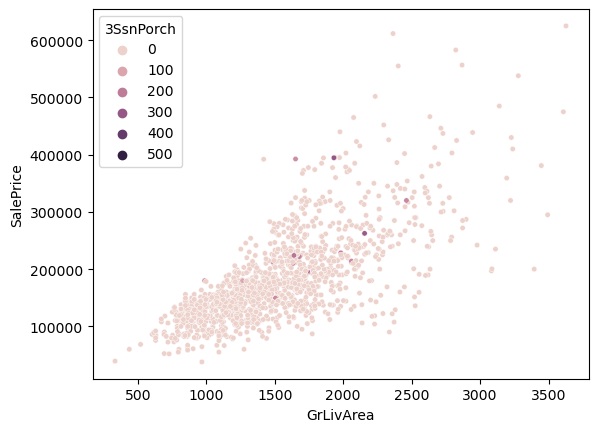

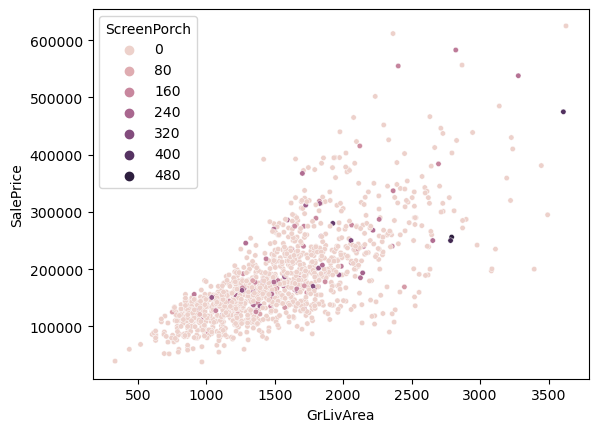

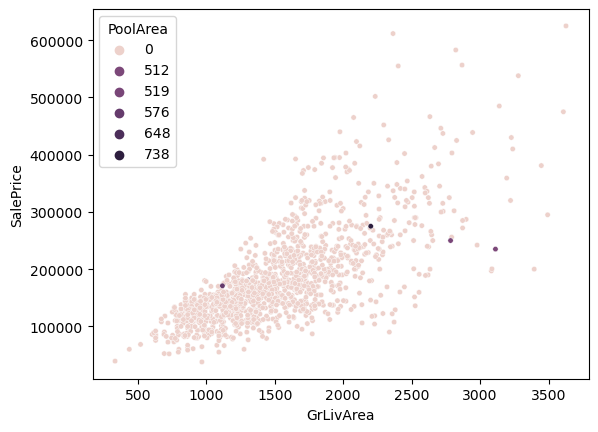

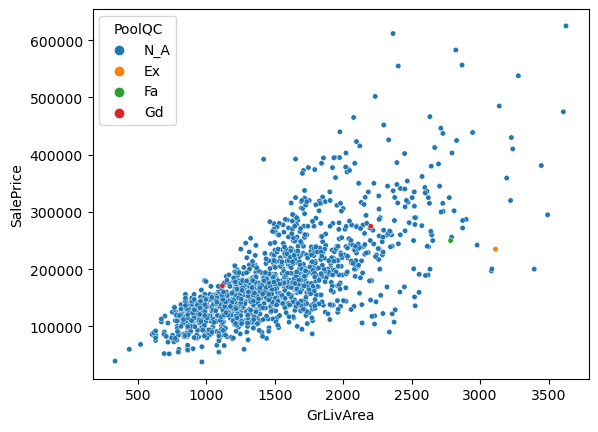

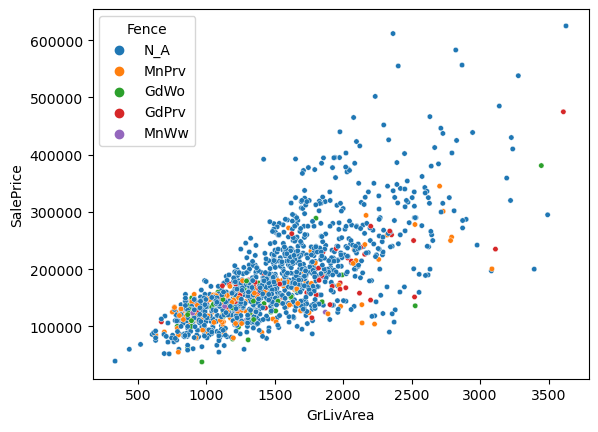

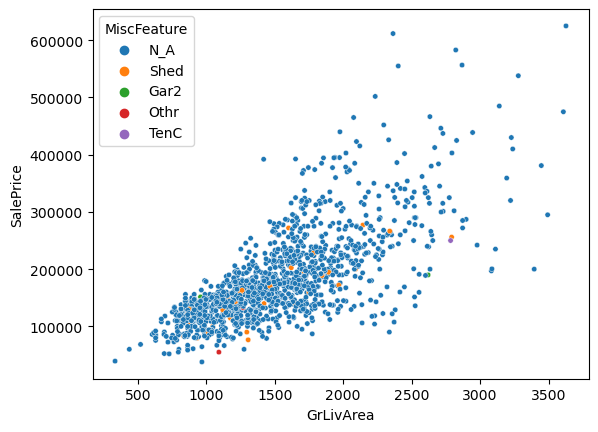

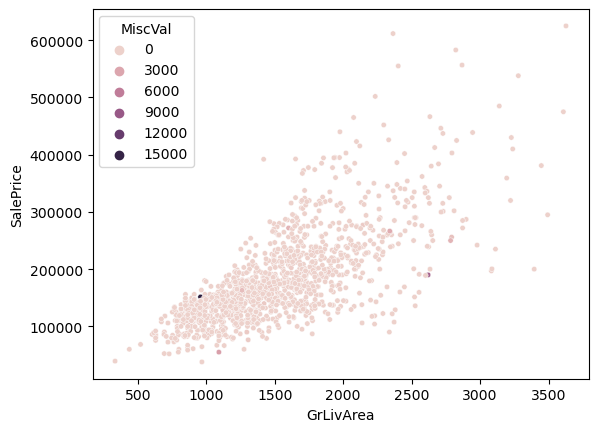

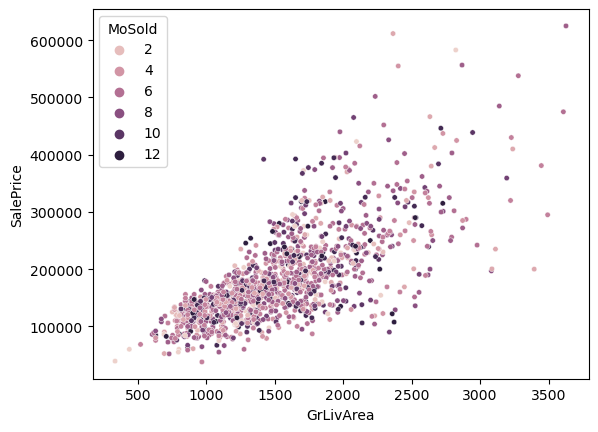

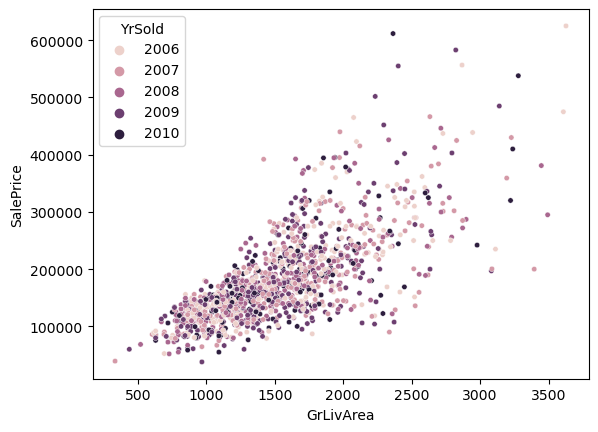

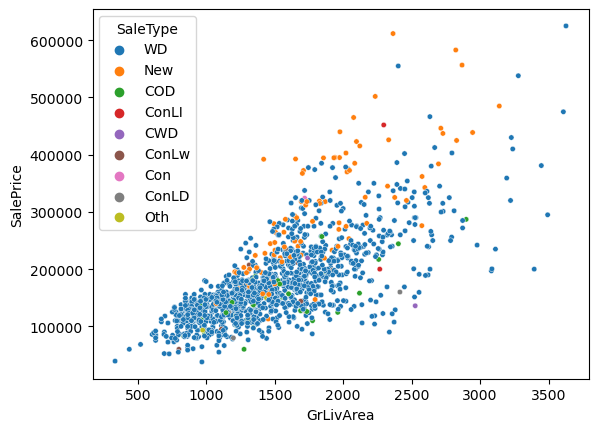

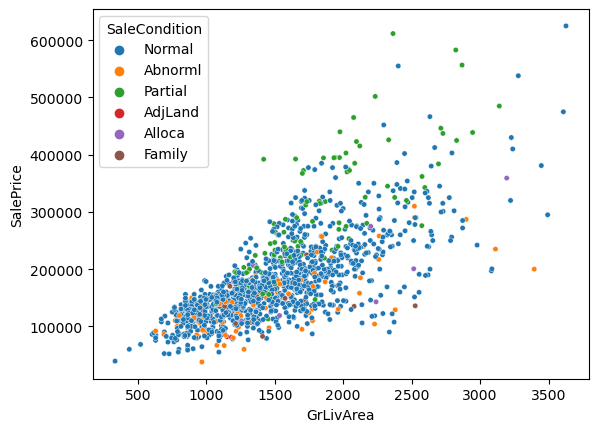

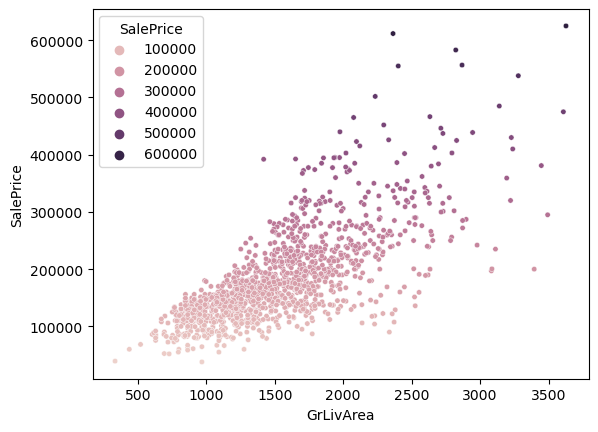

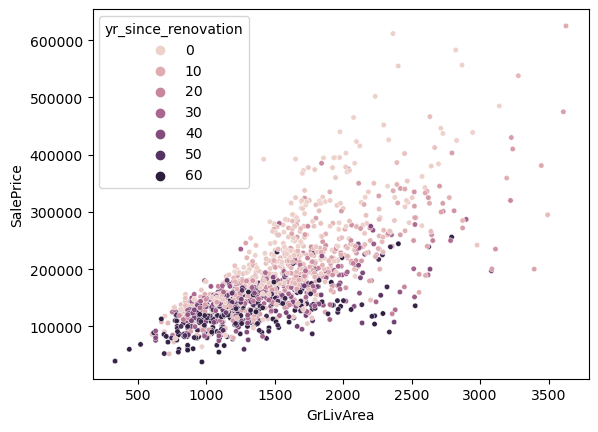

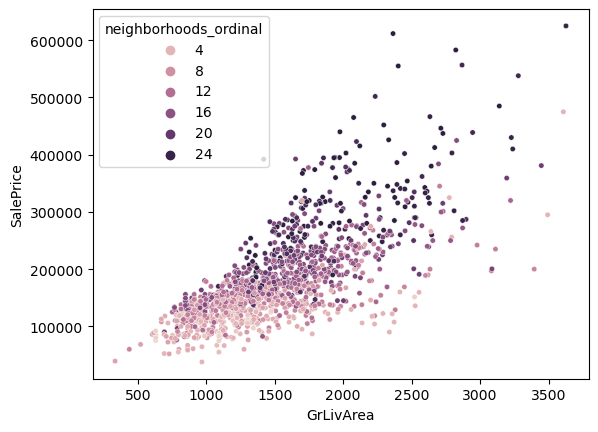

In [29]:
for col in list(train.columns):
    sns.scatterplot(x='GrLivArea', y='SalePrice', hue=col, s=15, data=train)
    plt.show()

### Modeling

In [30]:
from catboost import Pool, CatBoostRegressor

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [32]:
def extract_cat_features(data):
    cat_features = []
    num_features = []
    for i, col in enumerate(data.columns):
        if data[col].dtype == 'object':
            cat_features.append(col)
        #elif data[col].max() <= 15:
        #    cat_features.append(col)
        else:
            num_features.append(col)
    #cat_features.append('MSSubClass') #!! is numeric but represents categories
    return cat_features, num_features

In [33]:
def prepare_and_split_data(input_data, test_size=0):
    data = input_data.copy()
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col].fillna('N_A', inplace=True)
        else:
            data[col].fillna(0, inplace=True)
    X = data.drop('SalePrice', axis=1)
    y = data['SalePrice']
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [34]:
cat_features, num_features = extract_cat_features(train)

In [35]:
X_train, X_test, y_train, y_test = prepare_and_split_data(train, test_size=.05)

In [36]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)

#test_pool = Pool(test, 
#                 cat_features=cat_features) 

eval_pool = Pool(X_test, 
                 y_test, 
                 cat_features=cat_features)

# specify the training parameters 
model = CatBoostRegressor(iterations=900, 
                          depth=2, 
                          learning_rate=0.1, 
                          loss_function='MAE',
                          l2_leaf_reg=7,
                          one_hot_max_size=30,
                          #od_type = "Iter",
                          #od_wait = 100,
                          random_state=42,
                          random_strength=1,
                          
                          #ignored_features=ignored_features,
                          
                          verbose=100
                          )
#train the model
model.fit(train_pool)#, eval_set=eval_pool, early_stopping_rounds=20)
# make the prediction using the resulting model
preds = model.predict(eval_pool)

0:	learn: 51206.5499149	total: 58.1ms	remaining: 52.2s
100:	learn: 14905.0063690	total: 103ms	remaining: 812ms
200:	learn: 12807.4112456	total: 145ms	remaining: 505ms
300:	learn: 12043.1084093	total: 190ms	remaining: 378ms
400:	learn: 11395.2056453	total: 234ms	remaining: 291ms
500:	learn: 10955.1280940	total: 278ms	remaining: 222ms
600:	learn: 10525.1032151	total: 322ms	remaining: 160ms
700:	learn: 10261.5801147	total: 366ms	remaining: 104ms
800:	learn: 9932.2668542	total: 411ms	remaining: 50.8ms
899:	learn: 9700.3327983	total: 454ms	remaining: 0us


In [37]:
np.sqrt(mean_squared_error(preds, y_test))

17707.139427375005

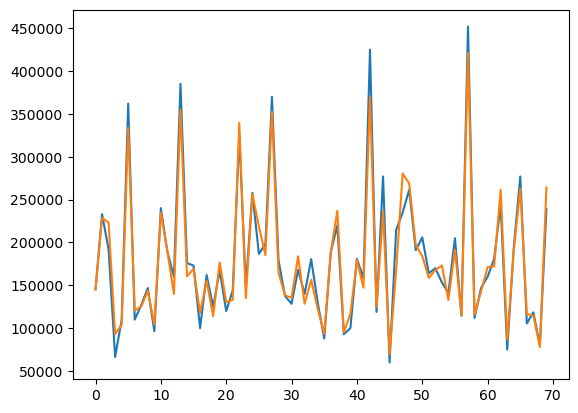

In [38]:
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test)), pd.Series(preds))

In [39]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0             OverallQual    19.329735
1               GrLivArea    18.697597
2   neighborhoods_ordinal    12.890401
3               YearBuilt     6.036751
4              GarageCars     4.741333
5               ExterQual     4.228892
6             TotalBsmtSF     4.130527
7              BsmtFinSF1     4.117557
8              GarageArea     3.878974
9                1stFlrSF     3.490781
10                LotArea     2.636542
11            FireplaceQu     2.083668
12            KitchenQual     2.082679
13               2ndFlrSF     1.480726
14            OverallCond     1.066020
15           YearRemodAdd     0.862485
16               HalfBath     0.759893
17            GarageYrBlt     0.650231
18              RoofStyle     0.615472
19             WoodDeckSF     0.502258
20          SaleCondition     0.457856
21           BsmtFullBath     0.403564
22            ScreenPorch     0.348791
23             Functional     0.297404
24               MSZoning     0.243298
25            OpenPorchSF     0.240994
26              LotConfig     0.211993
27               SaleType     0.209012
28             CentralAir     0.208396
29              BsmtUnfSF     0.205978
30           LowQualFinSF     0.200494
31           GarageFinish     0.195898
32           KitchenAbvGr     0.195221
33               BsmtCond     0.185234
34           BsmtExposure     0.171667
35           BsmtFinType2     0.168484
36    yr_since_renovation     0.166885
37             GarageType     0.158528
38             GarageQual     0.141830
39             Condition1     0.138262
40                 MoSold     0.122362
41           TotRmsAbvGrd     0.120155
42             MasVnrType     0.107026
43             BsmtFinSF2     0.100466
44            Exterior2nd     0.097831
45               BldgType     0.078074
46             MSSubClass     0.077123
47           BedroomAbvGr     0.067088
48              3SsnPorch     0.057215
49           BsmtFinType1     0.052998
50          EnclosedPorch     0.052928
51              LandSlope     0.039437
52             HouseStyle     0.032689
53             Condition2     0.031275
54                  Alley     0.021346
55            LandContour     0.019300
56               LotShape     0.016767
57           BsmtHalfBath     0.010093
58                MiscVal     0.009542
59                  Fence     0.008529
60               PoolArea     0.007016
61                 YrSold     0.005755
62            Exterior1st     0.005670
63             Foundation     0.004784
64               FullBath     0.003987
65               RoofMatl     0.003973
66              ExterCond     0.002645
67              HeatingQC     0.002474
68             PavedDrive     0.002448
69               BsmtQual     0.002349
70             GarageCond     0.002255
71             Electrical     0.001556
72            MiscFeature     0.000268
73                Heating     0.000266
74                 Street     0.000000
75              Utilities     0.000000
76             MasVnrArea     0.000000
77             Fireplaces     0.000000
78                 PoolQC     0.000000

### Submission

In [40]:
X, y = prepare_and_split_data(train)

In [41]:
sub_train_pool = Pool(X, y, 
                 cat_features=cat_features)

In [42]:
model.fit(sub_train_pool)

0:	learn: 51906.2823639	total: 1.13ms	remaining: 1.02s
100:	learn: 15137.6490078	total: 59.9ms	remaining: 474ms
200:	learn: 13068.4348969	total: 110ms	remaining: 383ms
300:	learn: 11967.7727152	total: 156ms	remaining: 311ms
400:	learn: 11331.9736184	total: 202ms	remaining: 251ms
500:	learn: 10833.4370336	total: 248ms	remaining: 198ms
600:	learn: 10440.0597510	total: 294ms	remaining: 146ms
700:	learn: 10093.8663403	total: 341ms	remaining: 96.8ms
800:	learn: 9821.8375328	total: 386ms	remaining: 47.7ms
899:	learn: 9590.5544580	total: 432ms	remaining: 0us


In [43]:
test = pd.read_csv('test_processed.csv')

In [44]:
preds = model.predict(test)

In [45]:
preds

array([128771.71456028, 157084.1687714 , 188179.26805069, ...,
       172853.62203288, 118870.59032667, 220413.41926755])

In [46]:
test_id = pd.read_csv('test.csv')

In [47]:
sub_test = test_id.copy()

In [48]:
sub_test['SalePrice'] = pd.Series(preds)

### Output

In [49]:
#sub_test[['Id', 'SalePrice']].to_csv('out.csv', index=False)